In [14]:
import sklearn
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import numpy as np


train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

train['date'] = train['date'].apply(lambda x : str(x[:6]))
test['date'] = test['date'].apply(lambda x : str(x[:6]))
train.drop("id", inplace=True, axis=1)
test_id = test['id']
test.drop("id", inplace=True, axis=1)

# Feature engineering
[O] 결측치  
[O] 공선성  

/home/jisu/AIFFEL/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


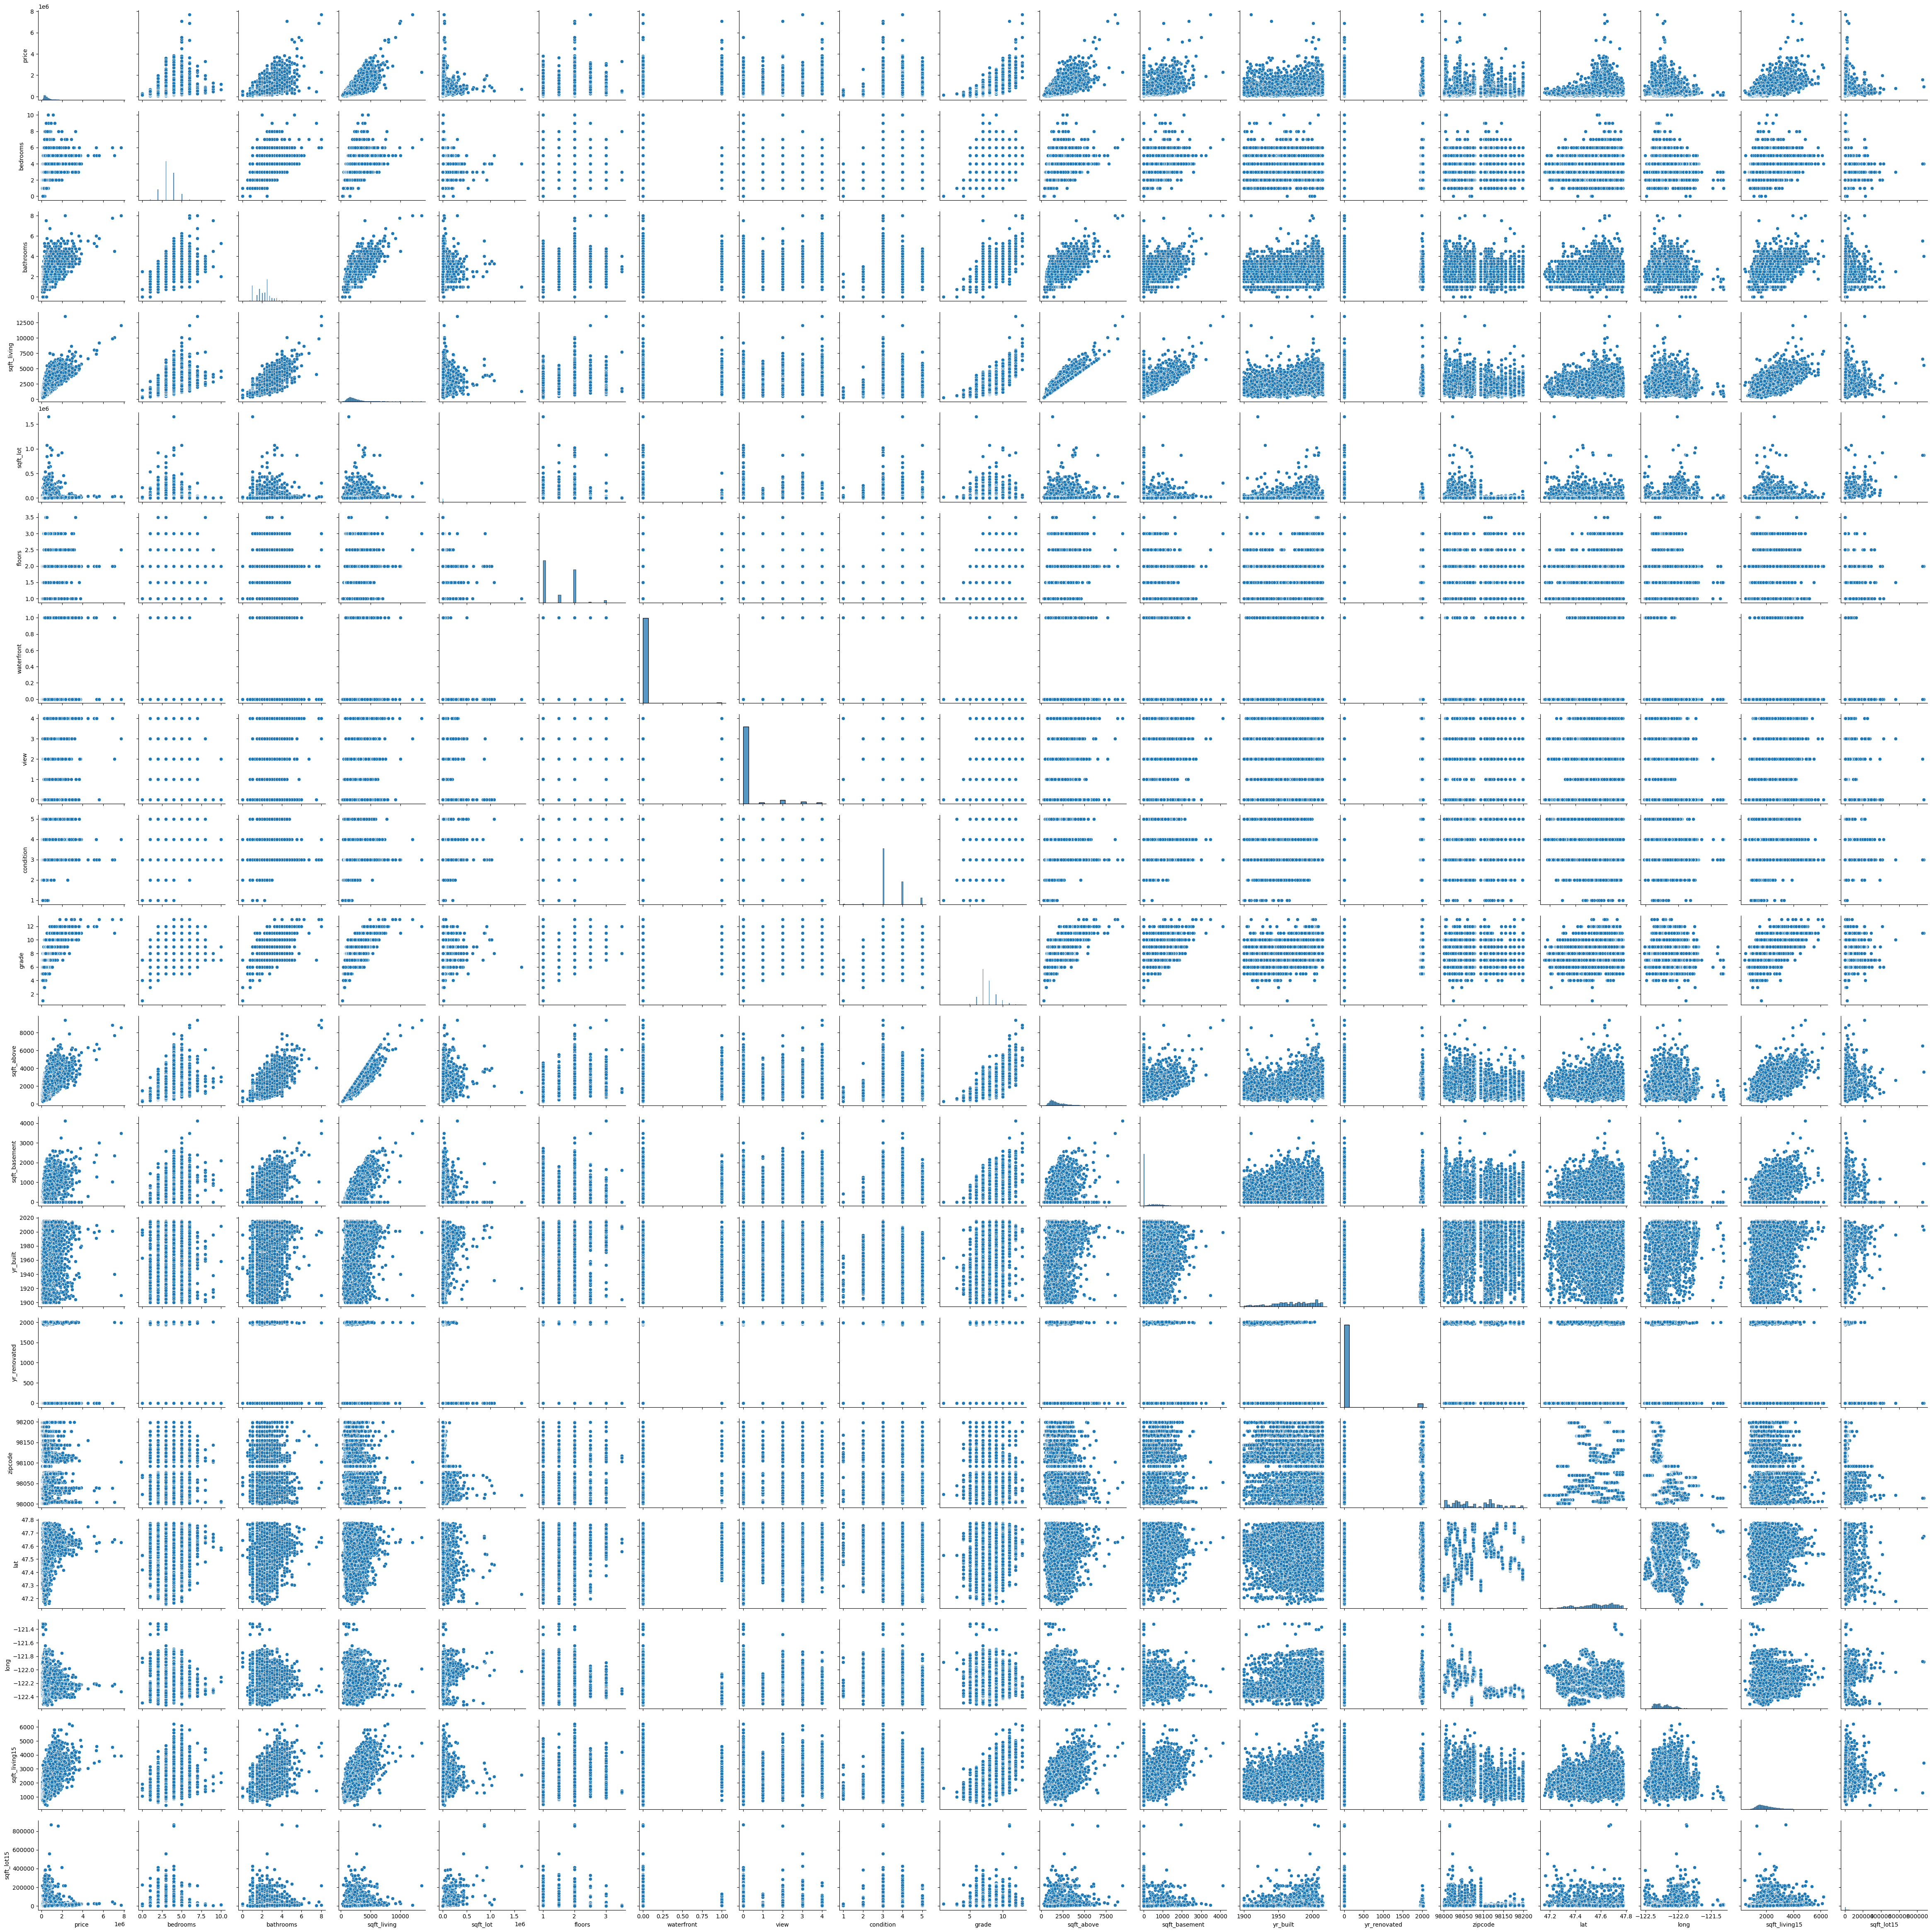

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(train)

## 중복치

In [15]:
display(train[train.duplicated()])

Empty DataFrame
Columns: [date, price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15]
Index: []

## 이상치
제거 효과 없음

In [16]:
def outlier_iqr(df, col, scale=1.8):
    quartile_1, quartile_3 = np.percentile(df[col], [25, 75]) 
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * scale)
    upper_bound = quartile_3 + (iqr * scale)

    return df.loc[(lower_bound > df[col]) | (upper_bound < df[col])]


numeric_df = train.select_dtypes("number")
for column in numeric_df.columns:
    index = outlier_iqr(numeric_df, column).index
    train.drop(index, axis=0)


display(train)

date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0      201410   221900.0         3       1.00         1180      5650     1.0   
1      201502   180000.0         2       1.00          770     10000     1.0   
2      201502   510000.0         3       2.00         1680      8080     1.0   
3      201406   257500.0         3       2.25         1715      6819     2.0   
4      201501   291850.0         3       1.50         1060      9711     1.0   
...       ...        ...       ...        ...          ...       ...     ...   
15030  201410   610685.0         4       2.50         2520      6023     2.0   
15031  201503  1007500.0         4       3.50         3510      7200     2.0   
15032  201405   360000.0         3       2.50         1530      1131     3.0   
15033  201502   400000.0         4       2.50         2310      5813     2.0   
15034  201410   325000.0         2       0.75         1020      1076     2.0   

       waterfront  view  condition  grade  sqft_above  sqft_basement  \
0               0     0          3      7        1180              0   
1               0     0          3      6         770              0   
2               0     0          3      8        1680              0   
3               0     0          3      7        1715              0   
4               0     0          3      7        1060              0   
...           ...   ...        ...    ...         ...            ...   
15030           0     0          3      9        2520              0   
15031           0     0          3      9        2600            910   
15032           0     0          3      8        1530              0   
15033           0     0          3      8        2310              0   
15034           0     0          3      7        1020              0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0          1955             0    98178  47.5112 -122.257           1340   
1          1933             0    98028  47.7379 -122.233           2720   
2          1987             0    98074  47.6168 -122.045           1800   
3          1995             0    98003  47.3097 -122.327           2238   
4          1963             0    98198  47.4095 -122.315           1650   
...         ...           ...      ...      ...      ...            ...   
15030      2014             0    98056  47.5137 -122.167           2520   
15031      2009             0    98136  47.5537 -122.398           2050   
15032      2009             0    98103  47.6993 -122.346           1530   
15033      2014             0    98146  47.5107 -122.362           1830   
15034      2008             0    98144  47.5941 -122.299           1020   

       sqft_lot15  
0            5650  
1            8062  
2            7503  
3            6819  
4            9711  
...           ...  
15030        6023  
15031        6200  
15032        1509  
15033        7200  
15034        1357  

[15035 rows x 20 columns]

## 정규화

효과 없음

In [17]:
from sklearn.preprocessing import MinMaxScaler


min_max_scaler = MinMaxScaler()

columns = numeric_df.loc[:, numeric_df.columns != "price"].columns
train[columns] = min_max_scaler.fit_transform(train[columns])
display(train)

columns = test.select_dtypes("number").columns
test[columns] = min_max_scaler.transform(test[columns])
display(test)



date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0      201410   221900.0       0.3    0.12500     0.067170  0.003108     0.0   
1      201502   180000.0       0.2    0.12500     0.036226  0.005743     0.0   
2      201502   510000.0       0.3    0.25000     0.104906  0.004579     0.0   
3      201406   257500.0       0.3    0.28125     0.107547  0.003816     0.4   
4      201501   291850.0       0.3    0.18750     0.058113  0.005567     0.0   
...       ...        ...       ...        ...          ...       ...     ...   
15030  201410   610685.0       0.4    0.31250     0.168302  0.003333     0.4   
15031  201503  1007500.0       0.4    0.43750     0.243019  0.004046     0.4   
15032  201405   360000.0       0.3    0.31250     0.093585  0.000370     0.8   
15033  201502   400000.0       0.4    0.31250     0.152453  0.003206     0.4   
15034  201410   325000.0       0.2    0.09375     0.055094  0.000337     0.4   

       waterfront  view  condition     grade  sqft_above  sqft_basement  \
0             0.0   0.0        0.5  0.500000    0.097588       0.000000   
1             0.0   0.0        0.5  0.416667    0.052632       0.000000   
2             0.0   0.0        0.5  0.583333    0.152412       0.000000   
3             0.0   0.0        0.5  0.500000    0.156250       0.000000   
4             0.0   0.0        0.5  0.500000    0.084430       0.000000   
...           ...   ...        ...       ...         ...            ...   
15030         0.0   0.0        0.5  0.666667    0.244518       0.000000   
15031         0.0   0.0        0.5  0.666667    0.253289       0.220339   
15032         0.0   0.0        0.5  0.583333    0.135965       0.000000   
15033         0.0   0.0        0.5  0.583333    0.221491       0.000000   
15034         0.0   0.0        0.5  0.500000    0.080044       0.000000   

       yr_built  yr_renovated   zipcode       lat      long  sqft_living15  \
0      0.478261           0.0  0.893939  0.571498  0.217608       0.161934   
1      0.286957           0.0  0.136364  0.936143  0.237542       0.399415   
2      0.756522           0.0  0.368687  0.741354  0.393688       0.241094   
3      0.826087           0.0  0.010101  0.247386  0.159468       0.316469   
4      0.547826           0.0  0.994949  0.407914  0.169435       0.215281   
...         ...           ...       ...       ...       ...            ...   
15030  0.991304           0.0  0.277778  0.575519  0.292359       0.364997   
15031  0.947826           0.0  0.681818  0.639858  0.100498       0.284116   
15032  0.947826           0.0  0.515152  0.874055  0.143688       0.194631   
15033  0.991304           0.0  0.732323  0.570693  0.130399       0.246257   
15034  0.939130           0.0  0.722222  0.704842  0.182724       0.106866   

       sqft_lot15  
0        0.005742  
1        0.008513  
2        0.007871  
3        0.007085  
4        0.010407  
...           ...  
15030    0.006171  
15031    0.006374  
15032    0.000986  
15033    0.007523  
15034    0.000811  

[15035 rows x 20 columns]

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0     201412       0.3    0.28125     0.172075  0.004072     0.4         0.0   
1     201412       0.4    0.37500     0.126038  0.002714     0.0         0.0   
2     201405       0.4    0.56250     0.387170  0.061429     0.0         0.0   
3     201504       0.3    0.12500     0.112453  0.004210     0.0         0.0   
4     201503       0.3    0.31250     0.120755  0.003659     0.4         0.0   
...      ...       ...        ...          ...       ...     ...         ...   
6463  201406       0.3    0.21875     0.091321  0.006935     0.0         0.0   
6464  201501       0.3    0.25000     0.090566  0.000367     0.8         0.0   
6465  201502       0.3    0.31250     0.076981  0.000469     0.4         0.0   
6466  201406       0.2    0.09375     0.055094  0.000503     0.4         0.0   
6467  201501       0.3    0.31250     0.098868  0.001132     0.4         0.0   

      view  condition     grade  sqft_above  sqft_basement  yr_built  \
0      0.0        0.5  0.500000    0.206140       0.096852  0.443478   
1      0.0        1.0  0.500000    0.083333       0.220339  0.565217   
2      0.0        0.5  0.833333    0.394737       0.370460  0.878261   
3      0.0        0.5  0.500000    0.083333       0.176755  0.521739   
4      0.0        0.5  0.500000    0.175439       0.000000  0.895652   
...    ...        ...       ...         ...            ...       ...   
6463   0.0        0.5  0.416667    0.132675       0.000000  0.991304   
6464   0.0        0.5  0.583333    0.131579       0.000000  0.991304   
6465   0.0        0.5  0.583333    0.097588       0.031477  0.939130   
6466   0.0        0.5  0.500000    0.080044       0.000000  0.947826   
6467   0.0        0.5  0.583333    0.143640       0.000000  0.904348   

      yr_renovated   zipcode       lat      long  sqft_living15  sqft_lot15  
0         0.988089  0.626263  0.908959  0.166113       0.222165    0.008027  
1         0.000000  0.681818  0.586939  0.104651       0.165376    0.004996  
2         0.000000  0.262626  0.804568  0.426910       0.750473    0.116339  
3         0.000000  0.732323  0.573267  0.151163       0.237653    0.008572  
4         0.000000  0.186869  0.341805  0.405316       0.342626    0.007948  
...            ...       ...       ...       ...            ...         ...  
6463      0.000000  0.045455  0.247065  0.429402       0.158493    0.012236  
6464      0.000000  0.722222  0.665916  0.191860       0.172260    0.000665  
6465      0.000000  0.580808  0.677819  0.091362       0.160213    0.000705  
6466      0.000000  0.722222  0.705324  0.182724       0.106866    0.001558  
6467      0.000000  0.131313  0.608975  0.373754       0.173980    0.000731  

[6468 rows x 19 columns]

## 로그변환

In [18]:

columns = ['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15', 'bedrooms']

train[columns] = np.log1p(train[columns])
test[columns] = np.log1p(test[columns])


<Axes: >

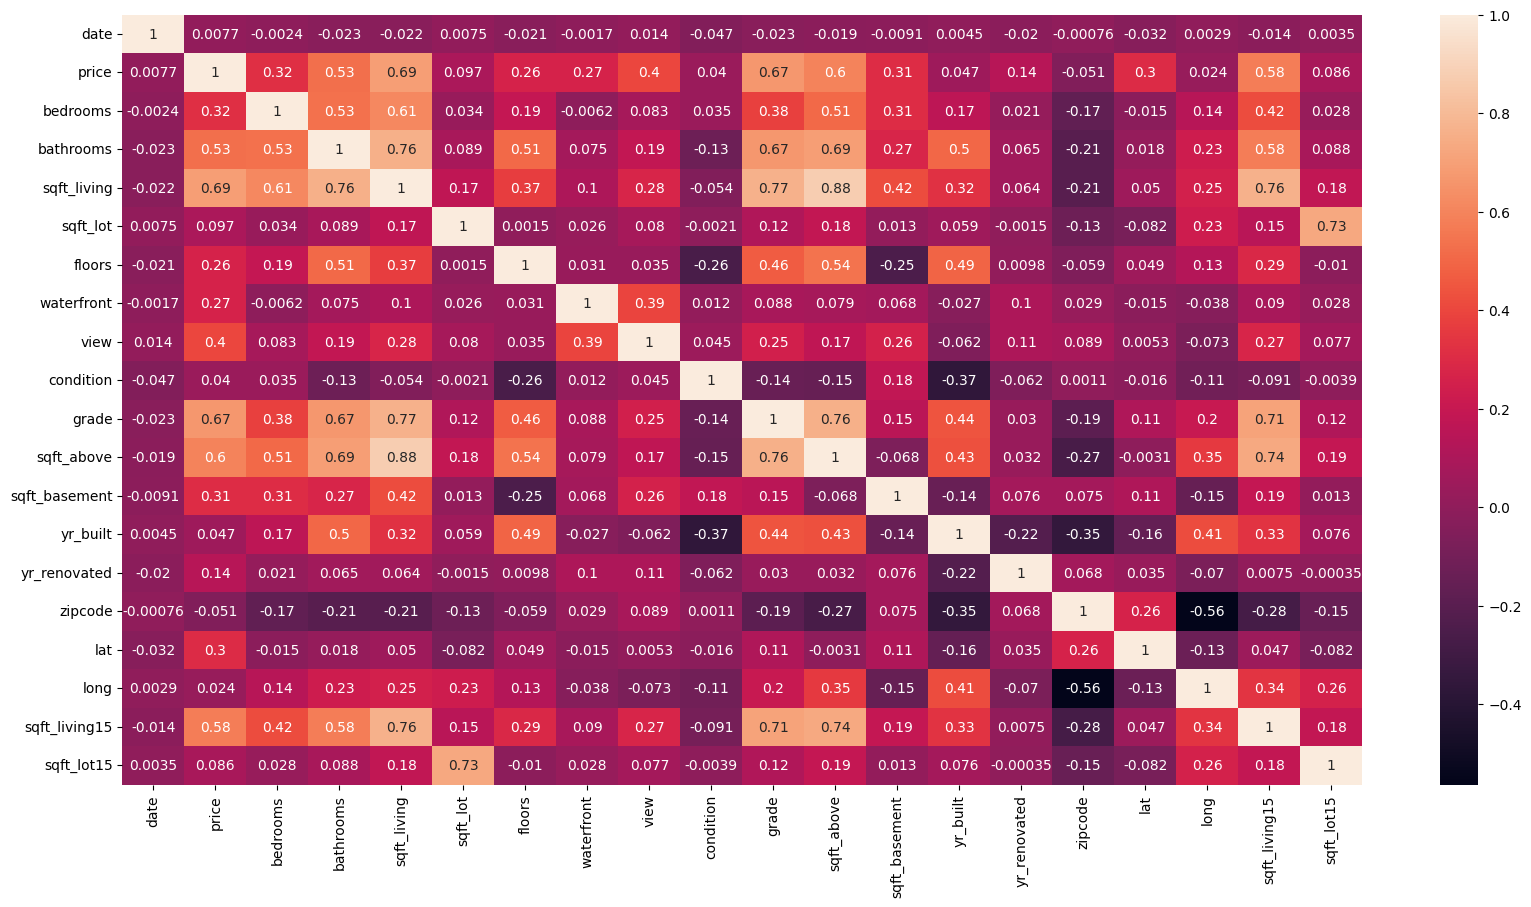

In [6]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(train.corr(), annot=True)

<Axes: >

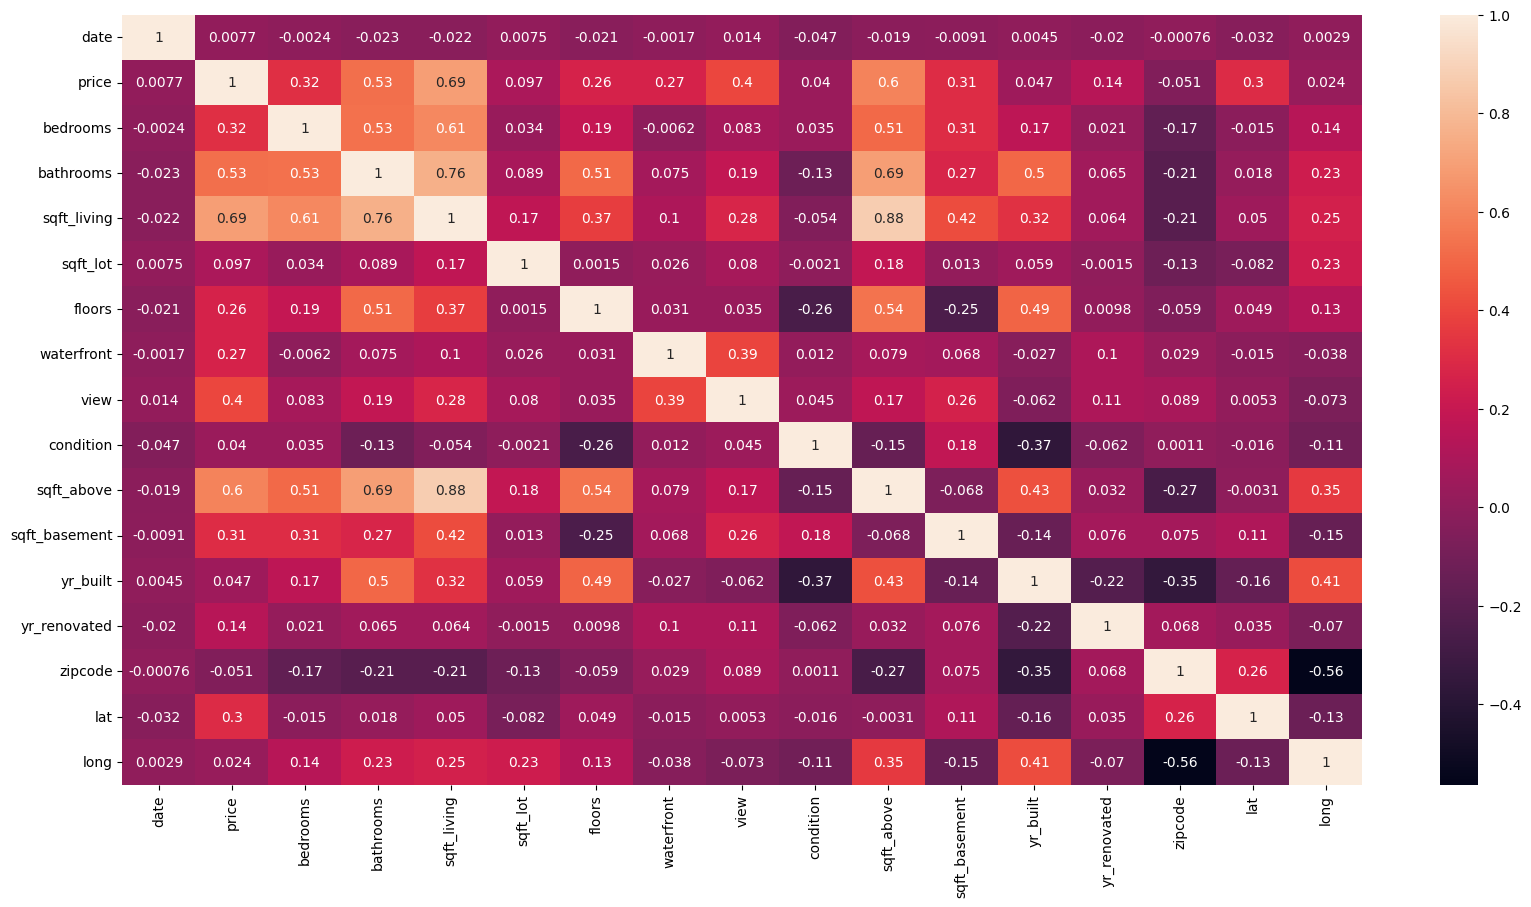

In [119]:
drops = ["grade", "sqft_living15", "sqft_lot15"]
train_copy = train.drop(drops, axis=1)
test_copy = test.drop(drops, axis=1)

fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(train_copy.corr(), annot=True)

In [120]:
x = train_copy.loc[:, train_copy.columns!="price"].values
y = train_copy['price'].values
y = np.log1p(y)
x_test = test_copy.loc[:, test_copy.columns!="price"].values

# 최적의 조합 찾기

In [75]:
from sklearn.model_selection import GridSearchCV

gboost = GradientBoostingRegressor()
xgboost = XGBRegressor()
lightgbm = LGBMRegressor()
rdforest = RandomForestRegressor()

models = [gboost, xgboost, lightgbm, rdforest]


def GridSearch(model, x, y, param_grid, verbose=3, n_jobs=16):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring="r2", \
                              cv=10, verbose=verbose, n_jobs=n_jobs)
    # 모델 fitting
    grid_model.fit(x, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['mean'] = score
    results['score'] = model.score(x, y)

    return results

In [186]:
param_grids = [
    {
        "n_estimators": [50, 100]
    },
    {
        "max_depth": [6, 12]
    },
    {
        "max_depth": [10, 50],
        "learning_rate": [0.001, 0.03],
        "n_estimators": [100],
        "boosting_type": ["gbdt"]
    },
    {
        "max_depth": [6, 12]
    }
]

for model,param_grid in zip(models, param_grids):
    print(f"\033[96m;{model.__name__}\033[0m;")
    print(GridSearch(model, x, y, param_grid, verbose=0))


   n_estimators      mean     score
0            50  0.836493  0.904347
1           100  0.861008  0.904347

   max_depth      mean     score
0          6  0.886686  0.979771
1         12  0.863565  0.979771

  boosting_type  learning_rate  max_depth  n_estimators      mean     score
0          gbdt          0.001         10           100  0.130825  0.899428
1          gbdt          0.001         50           100  0.130825  0.899428
2          gbdt          0.030         10           100  0.860764  0.899428
3          gbdt          0.030         50           100  0.860877  0.899428

   max_depth      mean     score
0          6  0.802012  0.981521
1         12  0.861810  0.981521


# 앙상블

In [121]:
gboost = GradientBoostingRegressor()
xgboost = XGBRegressor()
lightgbm = LGBMRegressor()
rdforest = RandomForestRegressor(max_depth=50)

models = [gboost, xgboost, lightgbm, rdforest]


def AveragingBlending(models, x, y, x_test):
    y_preds = []
    for model in models:
        model.fit(x, y)
        print(model.score(x, y))
        y_pred = model.predict(x_test)
        y_pred = np.expm1(y_pred)
        y_preds.append(y_pred)
    
    predictions = np.column_stack(y_preds)

    return np.mean(predictions, axis=1)

y_pred = AveragingBlending(models, x, y, x_test)

0.8731914381574309
0.9551832806783296
0.9235055475968249
0.9835183861611304


# 제출

In [122]:
import kaggle


result = pd.DataFrame({
    "id": test_id,
    "price": y_pred
})
result.to_csv("./submission.csv", index=False)
kaggle.api.competition_submit_cli(file_name="submission.csv", competition="2019-2nd-ml-month-with-kakr", message="drop some feature because of colinearity")

100%|██████████| 153k/153k [00:02<00:00, 53.2kB/s] 


Successfully submitted to 2019 2nd ML month with KaKR

In [126]:
latest = kaggle.api.competitions_submissions_list("2019-2nd-ml-month-with-kakr", page=1)
#kaggle.api.competition_submissions_cli("2019-2nd-ml-month-with-kakr")

print(f"description                      private score    public score")
for record in latest[:5]:
    print(f"{record['description']:<128} {record['privateScore']:<16} {record['publicScore']:<16}")

description                      private score    public score
drop some feature because of colinearity                                                                                         126124.77312     127607.57121    
drop some feature because of colinearity                                                                                         119607.80724     125382.52299    
drop some feature because of colinearity                                                                                         151420.56827     150926.20957    
drop some feature because of colinearity                                                                                                                          
drop some feature because of colinearity                                                                                         150873.39919     151000.06647    
